In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

from sklearn import metrics


import copy

In [2]:
df = pd.read_csv('../data.csv')
df.head()

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,0,450,1115,1.728649,1.424695,2.118387,2.599742
1,1,450,1657,1.666194,1.334938,2.083841,2.663684
2,2,450,1650,1.700305,1.353933,2.105350,2.582390
3,3,450,1651,1.708622,1.350846,2.118855,2.583843
4,4,450,1665,1.696678,1.336587,2.063092,2.530545


In [3]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
# data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()
# data_split_modified_z_12 = data_split_modified_z.to_numpy()


# """ SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 16)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)

# data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [4]:
# list_of_dfs = np.split(data_split_modified_z_12, 10) # split data to make the stream
k_np = data_split_modified_z_12[0] # this numpy array is used for the initial k-means
list_of_dfs_rest = data_split_modified_z_12[1:8] # this data will be clustered using sequential k-means
list_of_scores = []
k = 4

In [5]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum(point1 - point2)**2)

In [6]:
def plot_iteration(data, labels, centrois, iteration):
    
    axes_labels = ['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead',]
    axes_feats = [[(0,1),(0,3),(0,2)],
                  [(1,3),(1,2),(2,3)],
                 ]
    nrows = 2
    ncols = 3
    figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(13,7))
    figure.suptitle(f'iteration {iteration}', fontsize= 16)
    for row in range(nrows):
        for col in range(ncols):
            feat = axes_feats[row][col]
            figure.tight_layout(rect=[0, 0.03, 1, 0.95])
            axs[row, col].scatter(data[:, feat[0]], data[:, feat[1]],  c=labels, cmap='rainbow', alpha=0.7)
            axs[row, col].set_ylabel(axes_labels[feat[1]])
            axs[row, col].set_xlabel(axes_labels[feat[0]])
            for i in range(len(centroids)):
                axs[row, col].scatter(centroids[i, feat[0]], centroids[i, feat[1]], c='black', marker='x')
                
    plt.show(figure)
    plt.close(figure)

In [7]:
def add_new_instance(means, counts, k, instance):
    # based on pseudo code from https://www.cs.princeton.edu/courses/archive/fall08/cos436/Duda/C/sk_means.htm
    
    # distancec of one point to the two clusters
    distance_instance_to_clusters = np.zeros(k)
    
    for i in range(k):
        # calculate the distance to each of the cluster means 
        distance_instance_to_clusters[i] = euclidean_distance(means[i], instance)
    
    closest_cluster = np.argmin(distance_instance_to_clusters)
    
    counts[closest_cluster] += 1
    
    means[closest_cluster] = means[closest_cluster] + (1 / counts[closest_cluster]) * (instance - means[closest_cluster])
    
    return closest_cluster, means, counts

In [8]:
def predict(centroids, data):
    distance_instance_to_clusters = np.zeros((len(data), k))
    for instance in range(len(data)):
        for cluster in range(k):
            distance_instance_to_clusters[instance, cluster] = euclidean_distance(data[instance, :-2], centroids[cluster])
        labels[instance] = np.argmin(distance_instance_to_clusters[instance])
    return labels 

In [9]:
def plot_progress(data, labels, title, centroids):
    figure, axs = plt.subplots(nrows=1, ncols=2,figsize=(14,4))
                               
    figure.suptitle(f'data {title}/10', fontsize= 16)
    
    axs[0].scatter(data[:,5], data[:,4], c=labels, cmap='rainbow', alpha=0.7)
    axs[0].set_ylabel('Number of cars')
    axs[0].set_xlabel('Time')
    if title > 7:
        axs[0].axvline(x=143, color='g')

    axs[1].scatter(data[:,1], data[:,3], c=labels, cmap='rainbow', alpha=0.7)
    axs[1].set_ylabel('3rd Quartile')
    axs[1].set_xlabel('1st Quartlie')
    for i in range(len(centroids)):
        axs[1].scatter(centroids[i,1], centroids[i, 3], c='black', marker='x')
                               
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show(figure)
    plt.close(figure)


In [10]:
def get_sil_score(data, labels):
    return metrics.silhouette_score(data, labels, metric='euclidean')

In [11]:
def get_cal_score(data, labels):
    return metrics.calinski_harabasz_score(data, labels)

In [12]:
from sklearn.metrics import davies_bouldin_score

def get_davies_score(data, labels):
    return davies_bouldin_score(data, labels)

# start with classic K-Means algorithm to initialize the clusters

In [13]:
feat_size = len(k_np[0]) - 2
number_of_samples = len(k_np)

centroids_old = np.zeros((k, feat_size))
centroids = np.zeros((k, feat_size))  # means of all the clusters
counts = np.zeros(k) # number of points for each of the cluster

labels_new = np.zeros(number_of_samples)

random_centroids = np.random.choice(number_of_samples, k, replace = False)

# initialize the clusters here
for index in range(k):
    centroids[index] = k_np[random_centroids[index], :-2]

# for loop for max number of iterations:
for iteration in range(100):
# make clusters    
    centroids_old = copy.deepcopy(centroids)
    
    #distances of each of the samples to each cluster
    distance_instance_to_clusters = np.zeros((number_of_samples, k))
    for instance in range(number_of_samples):
        for cluster in range(k):
            distance_instance_to_clusters[instance, cluster] = euclidean_distance(k_np[instance, :-2],centroids[cluster])
        # choose closets cluster for that instance
        labels_new[instance] = np.argmin(distance_instance_to_clusters[instance])
        
# update centroids
    for i in range(k):
        clusters = k_np[labels_new==i, :-2]
        centroids[i] = np.mean(clusters, axis=0)

# plot each iteration for debugging
#     plot_iteration(k_np, labels_new, centroids, iteration)
    
# check if converged
    centroid_distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(k)]
    if sum(centroid_distances) == 0:
        print(f'Converged somehow (?) at loop {iteration+1}')
        break
        
    

Converged somehow (?) at loop 3


In [14]:
labels = copy.deepcopy(labels_new)
old_data = copy.deepcopy(k_np)


In [15]:
labels_dict = {}
labels_dict[f'fit_1'] = labels
list_of_nmpys_for_graphs = []
list_of_nmpys_for_graphs.append(old_data)

len(list_of_dfs_rest[0])

labels_for_plotting = np.zeros(26)


In [16]:
counter = 2
s = get_sil_score(old_data[:, :-2], labels_dict[f'fit_1'])
c = get_cal_score(old_data[:, :-2], labels_dict[f'fit_1'])
d = get_davies_score(old_data[:, :-2], labels_dict[f'fit_1'])
list_of_scores.append(s)
for set_df in list_of_dfs_rest:
    new_data = set_df
    for index in range(len(new_data)):
        label, centroids, counts = add_new_instance(centroids, counts, k, new_data[index, :-2])
        labels = np.append(labels, label)
        old_data = np.append(old_data, new_data[index].reshape(1,-1), axis=0)
    
    labels_dict[f'fit_{counter}'] = predict(centroids,old_data)
    list_of_nmpys_for_graphs.append(old_data)
#     plot_progress(old_data, labels_dict[f'fit_{counter}'], counter, centroids)
    s = get_sil_score(old_data[:, :-2], labels_dict[f'fit_{counter}'])
    c = get_cal_score(old_data[:, :-2], labels_dict[f'fit_{counter}'])
    d = get_davies_score(old_data[:, :-2], labels_dict[f'fit_{counter}'])
    list_of_scores.append(s)
    counter+=1

In [17]:
# get_sil_score(list_of_nmpys_for_graphs[-1], labels_dict[f'fit_{counter-1}'])

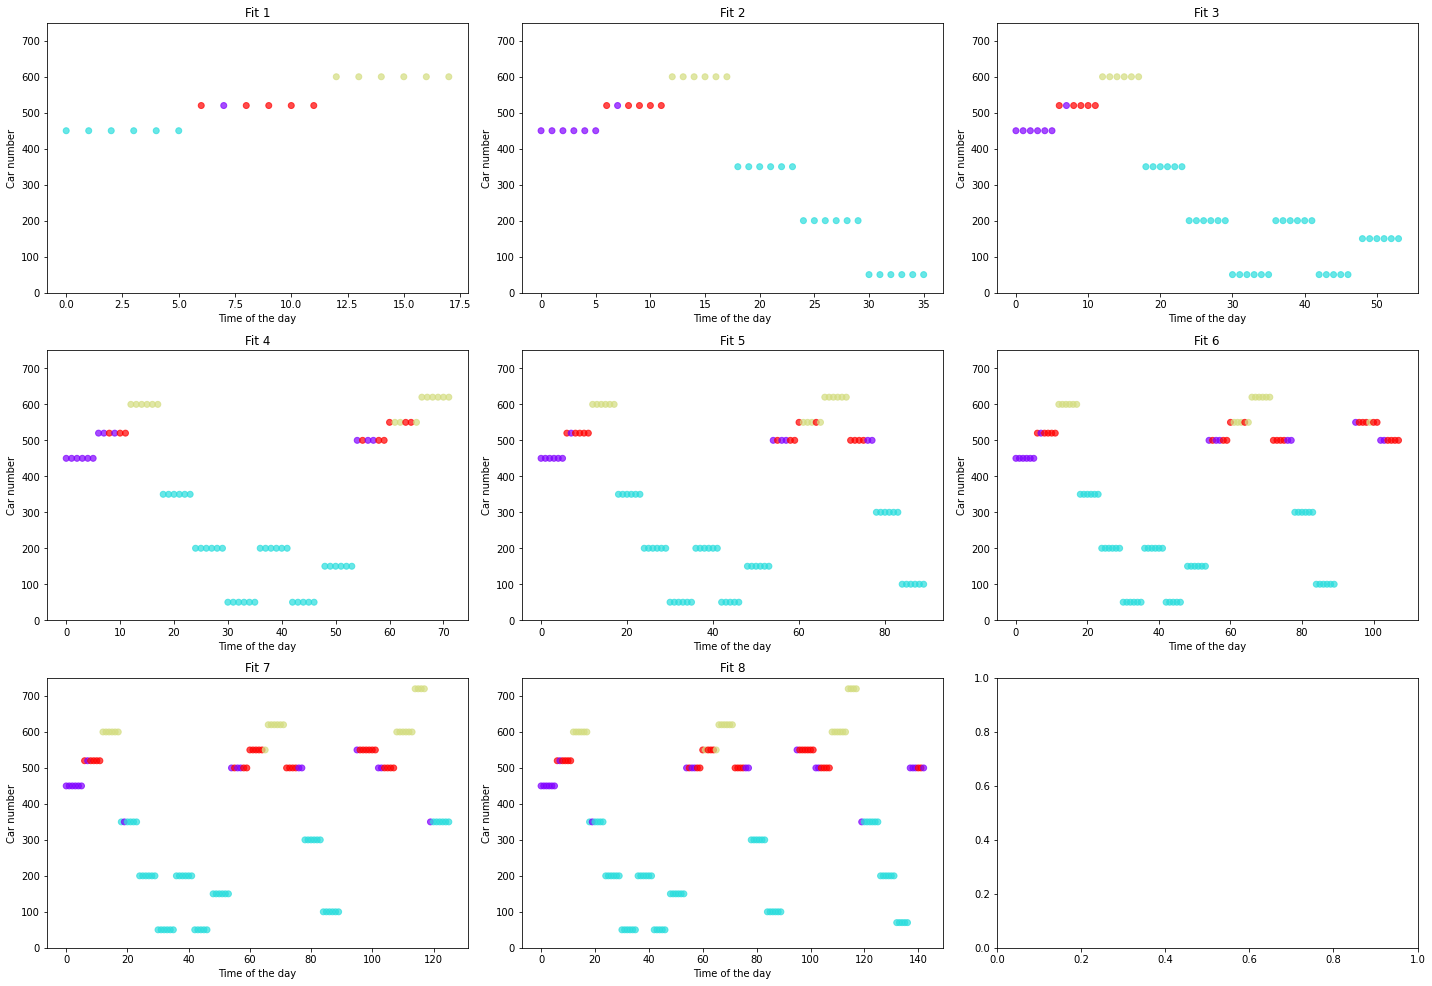

In [18]:
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 3
ncols = 3

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,15))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [19]:
list_of_dfs_rest_2 = data_split_modified_z_12[8:]

In [20]:
for set_df in list_of_dfs_rest_2:
    new_data = set_df
    for index in range(len(new_data)):
        label, centroids, counts = add_new_instance(centroids, counts, k, new_data[index, :-2])
        labels = np.append(labels, label)
        old_data = np.append(old_data, new_data[index].reshape(1,-1), axis=0)
    
    labels_dict[f'fit_{counter}'] = predict(centroids,old_data)
    list_of_nmpys_for_graphs.append(old_data)
#     plot_progress(old_data, labels_dict[f'fit_{counter}'], counter, centroids)
    s = get_sil_score(old_data[:, :-2], labels_dict[f'fit_{counter}'])
    c = get_cal_score(old_data[:, :-2], labels_dict[f'fit_{counter}'])
    d = get_davies_score(old_data[:, :-2], labels_dict[f'fit_{counter}'])
    list_of_scores.append(s)
    counter+=1

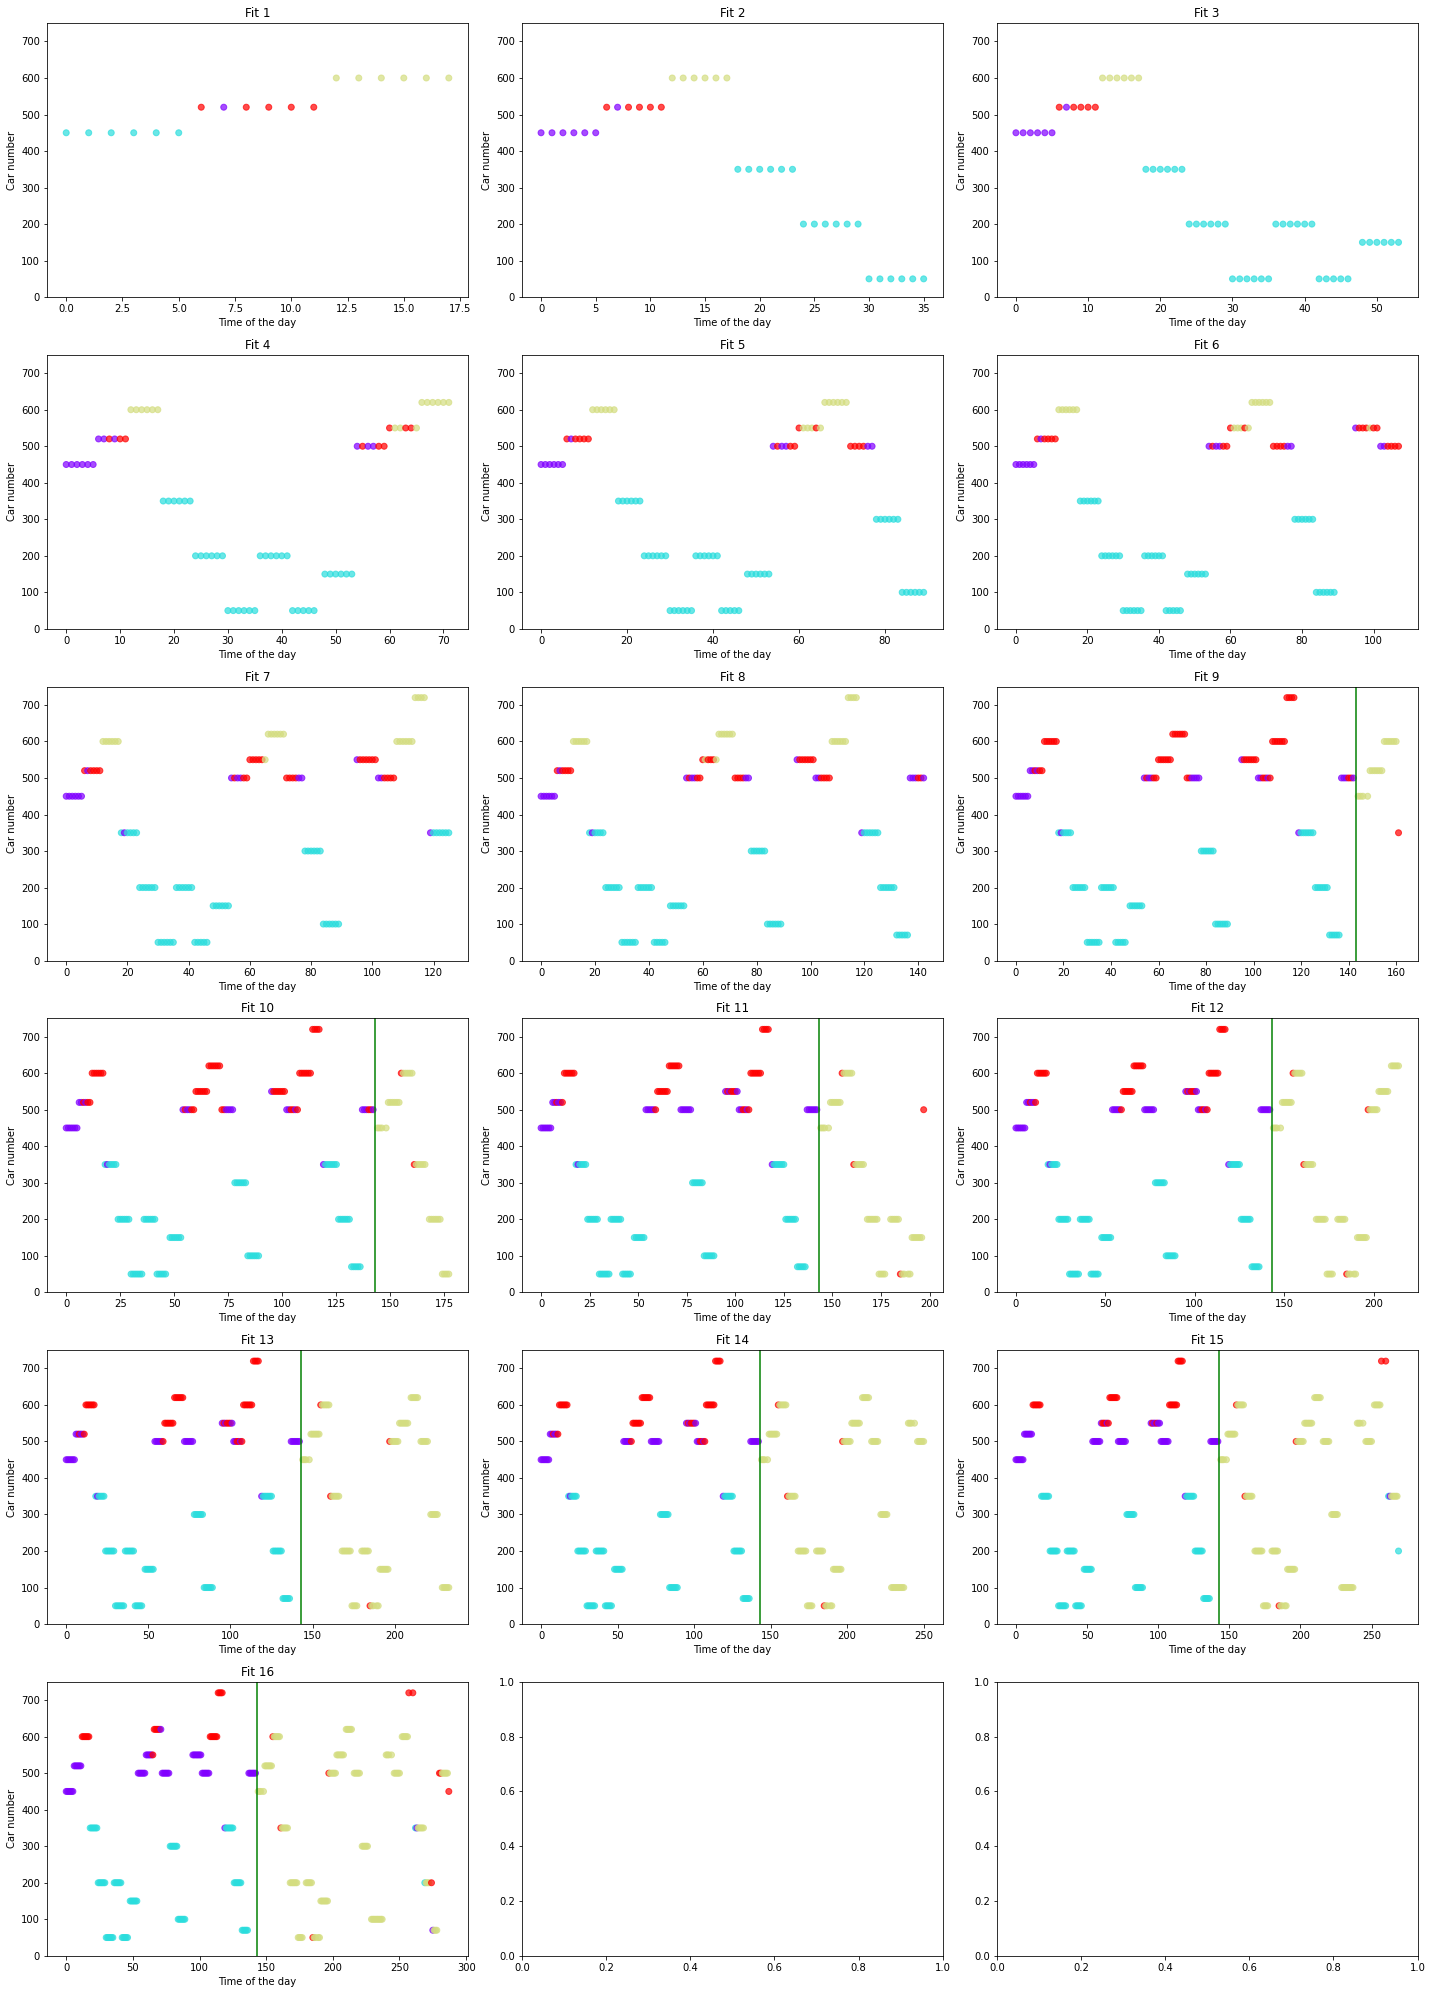

In [21]:
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 6
ncols = 3

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,30))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [22]:
fit_number = 1
outlier_dict = {}

for k in labels_dict:
#     print(k)
    arr = labels_dict[k]
#     print(arr)
    fit =  np.array_split(arr, 3*fit_number)
    outlier_counter = 0

    for value in fit: # value is each of the 6 points
#         print(value)
        ilosc = len(value)
        coun = np.array(np.unique(value, return_counts=True)).T
        for num in coun:
            p = (num[1]*100)/ilosc
    #   print(coun)
            if p < 49:
                outlier_counter += num[1]
#         if len(value) < 6:
#             print(f'revisit {k}')
        
    outlier_dict[k] = outlier_counter
#     if fit_number == 6:
#         print(fit)
#         print()
#         print(outlier_counter)
# #         break
    fit_number += 1 

#     break
outlier_dict

{'fit_1': 1.0,
 'fit_2': 1.0,
 'fit_3': 1.0,
 'fit_4': 5.0,
 'fit_5': 9.0,
 'fit_6': 16.0,
 'fit_7': 18.0,
 'fit_8': 18.0,
 'fit_9': 16.0,
 'fit_10': 17.0,
 'fit_11': 18.0,
 'fit_12': 18.0,
 'fit_13': 18.0,
 'fit_14': 20.0,
 'fit_15': 22.0,
 'fit_16': 26.0}

Text(0.5, 1.0, 'k = 4')

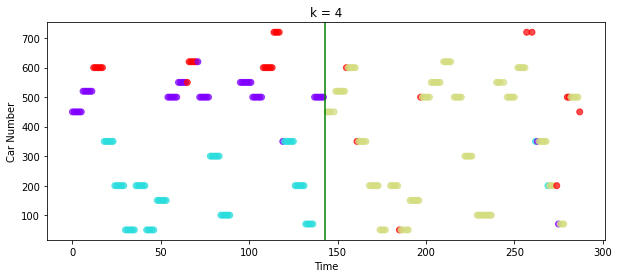

In [23]:
plt.figure(figsize=(10,4))

plt.scatter(list_of_nmpys_for_graphs[-1][:, 5], list_of_nmpys_for_graphs[-1][:, 4], c =labels_dict[f'fit_{counter-1}'], cmap='rainbow', alpha=0.7 )
plt.ylabel('Car Number')
plt.xlabel('Time')
plt.axvline(x=143, color='g')
plt.title('k = 4')

In [24]:
for score in list_of_scores:
    print(score)
# list_of_scores

0.45954238412016707
0.5112902296532229
0.5659326697098664
0.4777183743331144
0.5177109085213293
0.5151960505300833
0.4886355007286653
0.49823666521348914
0.4877880789771939
0.48795683114736255
0.5201228060699535
0.5459629814424913
0.5595961687737039
0.5711804941696645
0.5965587515023377
0.599620085650293
